## XGBoost - viscosity - 2bins - 50/50

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, r2_score, mean_absolute_error, root_mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
from sklearn import metrics
import pycm
from ast import literal_eval
import sys
sys.path.append("../plotutils/")
from plotutils import *
plt.style.use("../plotutils/your.mplstyle")
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator

In [2]:
df = pd.read_csv(f"../Viscosity_dataset.csv", sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Chemicals                                    100 non-null    object 
 1   SMILES                                       100 non-null    object 
 2   Temperature (kelvin)                         100 non-null    float64
 3   Dynamic Viscosity (cp)                       100 non-null    float64
 4   Classification (based on dynamic viscosity)  100 non-null    object 
 5   viscosity_2bins_5050                         100 non-null    int64  
 6   viscosity_7228                               100 non-null    int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 5.6+ KB


In [3]:
def smiles_to_fingerprint(smiles) -> np.ndarray:
    """
    Convert a SMILES string to a molecular fingerprint using RDKit.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    # generate Morgan fingerprint
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=20, fpSize=512)
    fingerprint = mfpgen.GetFingerprint(mol)

    return np.array(fingerprint)

In [4]:
df["mp_bin"] = df["SMILES"].apply(smiles_to_fingerprint)
df["mp_bin"]

0     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
2     [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                            ...                        
95    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
96    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
97    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
98    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
99    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: mp_bin, Length: 100, dtype: object

In [25]:
def prepare_dataset_classification(
    df,
    target = "viscosity_2bins_5050",
    representation = "mp_bin",
    random_state=42,
    train_size=80
):
    df_train, df_val_test = train_test_split(
        df,
        train_size=train_size,
        random_state=random_state,
        stratify=df[target].astype(int).values,
    )
    print(len(df_train), len(df_val_test))
    
    df_val, df_test = train_test_split(
        df_val_test,
        train_size=0.5,
        random_state=random_state,
        stratify=df_val_test[target].astype(int).values,
    )
    print(len(df_val), len(df_test))
    
    X_train, y_train = df_train[representation], df_train[target]
    X_val, y_val = df_val[representation], df_val[target]
    X_test, y_test = df_test[representation], df_test[target]
    
    return list(X_train), y_train, list(X_val), y_val, list(X_test), y_test

In [26]:
def train_and_evaluate_classifier(X_train, y_train, X_val, y_val, X_test, y_test, random_state=42):
    clf = XGBClassifier(
        #learning_rate = 0.1,
        n_estimators=200, 
        random_state=random_state, 
        early_stopping_rounds=10,
        objective="binary:logistic",
        #use_label_encoder=False, 
        eval_metric="logloss"
    )
    
    clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=5)
    
    y_pred = clf.predict(X_test)
    y_test = np.array(y_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_micro = f1_score(y_test, y_pred, average="micro")
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa

In [27]:
def metrics_dict():
    metrics_dict = {
        "train_size": train_size,
        "y_true": y_test_all,
        "y_pred": y_pred_all,
        "accuracy": acc_scores,
        "f1_macro": f1macro_scores,
        "f1_micro": f1micro_scores,
        "f1_weighted": f1weighted_scores,
        "kappa": kappa_scores
    }
    return metrics_dict

### training size = 40

In [28]:
train_size = 40
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [29]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val,
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
40 60
30 30
random_state = 42
[0]	validation_0-logloss:0.57373	validation_1-logloss:0.62672
[5]	validation_0-logloss:0.35327	validation_1-logloss:0.55520
[10]	validation_0-logloss:0.27182	validation_1-logloss:0.57288
[13]	validation_0-logloss:0.24276	validation_1-logloss:0.57586
Accuracy: 0.7666666666666667
F1 macro: 0.76
F1 micro: 0.7666666666666667
F1 weighted: 0.7599999999999999
Kappa: 0.5333333333333333
-------------Iteration 2/10
40 60
30 30
random_state = 43
[0]	validation_0-logloss:0.61595	validation_1-logloss:0.64419
[5]	validation_0-logloss:0.40169	validation_1-logloss:0.60002
[10]	validation_0-logloss:0.33739	validation_1-logloss:0.59398
[12]	validation_0-logloss:0.31950	validation_1-logloss:0.59741
Accuracy: 0.8
F1 macro: 0.7963800904977376
F1 micro: 0.8
F1 weighted: 0.7963800904977376
Kappa: 0.6
-------------Iteration 3/10
40 60
30 30
random_state = 44
[0]	validation_0-logloss:0.57765	validation_1-logloss:0.65531
[5]	validation_0-logloss:0.36650	

In [30]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 40
mean accuracy: 0.7133333333333334 +/- 0.054160256030906434
mean F1 macro: 0.7098432537340229 +/- 0.05441521140784133
mean F1 micro: 0.7133333333333334 +/- 0.054160256030906434
mean F1 weighted: 0.709843253734023 +/- 0.0544152114078413
mean Kappa: 0.42666666666666664 +/- 0.10832051206181278


In [31]:
compiled_res_40 = pd.DataFrame(metrics_dict())
compiled_res_40.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,40,"[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",0.766667,0.76000,0.766667,0.76000,0.533333
1,40,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, ...","[0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, ...",0.800000,0.79638,0.800000,0.79638,0.600000
2,40,"[1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, ...",0.700000,0.69697,0.700000,0.69697,0.400000


### training size = 50

In [32]:
train_size = 50
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [33]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val,
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
50 50
25 25
random_state = 42
[0]	validation_0-logloss:0.59174	validation_1-logloss:0.61256
[5]	validation_0-logloss:0.37718	validation_1-logloss:0.51869
[10]	validation_0-logloss:0.29428	validation_1-logloss:0.46877
[15]	validation_0-logloss:0.25011	validation_1-logloss:0.46655
[20]	validation_0-logloss:0.21904	validation_1-logloss:0.47376
[25]	validation_0-logloss:0.20134	validation_1-logloss:0.51037
Accuracy: 0.68
F1 macro: 0.6753246753246753
F1 micro: 0.68
F1 weighted: 0.676883116883117
Kappa: 0.3548387096774194
-------------Iteration 2/10
50 50
25 25
random_state = 43
[0]	validation_0-logloss:0.61790	validation_1-logloss:0.61902
[5]	validation_0-logloss:0.38452	validation_1-logloss:0.59591
[10]	validation_0-logloss:0.30185	validation_1-logloss:0.58203
[15]	validation_0-logloss:0.25941	validation_1-logloss:0.57601
[19]	validation_0-logloss:0.24837	validation_1-logloss:0.57940
Accuracy: 0.72
F1 macro: 0.7181964573268921
F1 micro: 0.72
F1 weighted: 0.71909

In [34]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 50
mean accuracy: 0.708 +/- 0.06939740629158989
mean F1 macro: 0.7033880840950673 +/- 0.07155650194589132
mean F1 micro: 0.708 +/- 0.06939740629158989
mean F1 weighted: 0.7043275252971127 +/- 0.07122190341926495
mean Kappa: 0.41325181127638266 +/- 0.13964023902185138


In [35]:
compiled_res_50 = pd.DataFrame(metrics_dict())
compiled_res_50.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,50,"[1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, ...",0.68,0.675325,0.68,0.676883,0.354839
1,50,"[0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, ...","[0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, ...",0.72,0.718196,0.72,0.719098,0.437299
2,50,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...","[0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...",0.68,0.675325,0.68,0.676883,0.354839


### training size = 60

In [36]:
train_size = 60
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [37]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val,
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
60 40
20 20
random_state = 42
[0]	validation_0-logloss:0.58831	validation_1-logloss:0.65293
[5]	validation_0-logloss:0.37479	validation_1-logloss:0.65261
[10]	validation_0-logloss:0.28379	validation_1-logloss:0.61381
[15]	validation_0-logloss:0.24305	validation_1-logloss:0.61755
[17]	validation_0-logloss:0.22958	validation_1-logloss:0.62749
Accuracy: 0.85
F1 macro: 0.8465473145780051
F1 micro: 0.85
F1 weighted: 0.846547314578005
Kappa: 0.7
-------------Iteration 2/10
60 40
20 20
random_state = 43
[0]	validation_0-logloss:0.59614	validation_1-logloss:0.67447
[5]	validation_0-logloss:0.37878	validation_1-logloss:0.71600
[10]	validation_0-logloss:0.29613	validation_1-logloss:0.80347
Accuracy: 0.9
F1 macro: 0.9
F1 micro: 0.9
F1 weighted: 0.9
Kappa: 0.8
-------------Iteration 3/10
60 40
20 20
random_state = 44
[0]	validation_0-logloss:0.57661	validation_1-logloss:0.63681
[5]	validation_0-logloss:0.39895	validation_1-logloss:0.56034
[10]	validation_0-logloss:0.289

In [38]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 60
mean accuracy: 0.735 +/- 0.10735455276791944
mean F1 macro: 0.7306868873338116 +/- 0.1084473528981998
mean F1 micro: 0.735 +/- 0.10735455276791944
mean F1 weighted: 0.7306868873338115 +/- 0.10844735289819978
mean Kappa: 0.47000000000000003 +/- 0.21470910553583888


In [39]:
compiled_res_60 = pd.DataFrame(metrics_dict())
compiled_res_60.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,60,"[0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ...",0.85,0.846547,0.85,0.846547,0.7
1,60,"[0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, ...","[0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, ...",0.90,0.900000,0.90,0.900000,0.8
2,60,"[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, ...",0.75,0.744246,0.75,0.744246,0.5


### training size = 70

In [40]:
train_size = 70
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [41]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val,
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
70 30
15 15
random_state = 42
[0]	validation_0-logloss:0.59358	validation_1-logloss:0.65756
[5]	validation_0-logloss:0.37234	validation_1-logloss:0.69442
[9]	validation_0-logloss:0.28852	validation_1-logloss:0.73976
Accuracy: 0.8
F1 macro: 0.7963800904977376
F1 micro: 0.8
F1 weighted: 0.7981900452488688
Kappa: 0.5945945945945946
-------------Iteration 2/10
70 30
15 15
random_state = 43
[0]	validation_0-logloss:0.59957	validation_1-logloss:0.62695
[5]	validation_0-logloss:0.36180	validation_1-logloss:0.54420
[10]	validation_0-logloss:0.27007	validation_1-logloss:0.56183
[12]	validation_0-logloss:0.24953	validation_1-logloss:0.59746
Accuracy: 0.8666666666666667
F1 macro: 0.8660714285714286
F1 micro: 0.8666666666666667
F1 weighted: 0.8666666666666667
Kappa: 0.7321428571428572
-------------Iteration 3/10
70 30
15 15
random_state = 44
[0]	validation_0-logloss:0.57175	validation_1-logloss:0.63182
[5]	validation_0-logloss:0.35426	validation_1-logloss:0.61681
[10]	v

In [42]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 70
mean accuracy: 0.72 +/- 0.10241527663824812
mean F1 macro: 0.7134953539752301 +/- 0.10724540245239025
mean F1 micro: 0.72 +/- 0.10241527663824812
mean F1 weighted: 0.7142649292571893 +/- 0.10723976676593207
mean Kappa: 0.4394362592116775 +/- 0.20392880776359215


In [43]:
compiled_res_70 = pd.DataFrame(metrics_dict())
compiled_res_70.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,70,"[0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1]","[0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1]",0.800000,0.796380,0.800000,0.798190,0.594595
1,70,"[0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1]","[0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1]",0.866667,0.866071,0.866667,0.866667,0.732143
2,70,"[0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1]","[0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1]",0.866667,0.866071,0.866667,0.865476,0.736842


### training size = 80

In [44]:
train_size = 80
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [45]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val,
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
80 20
10 10
random_state = 42
[0]	validation_0-logloss:0.56778	validation_1-logloss:0.62373
[5]	validation_0-logloss:0.33407	validation_1-logloss:0.47395
[10]	validation_0-logloss:0.25108	validation_1-logloss:0.42721
[15]	validation_0-logloss:0.20786	validation_1-logloss:0.38359
[20]	validation_0-logloss:0.18446	validation_1-logloss:0.36950
[25]	validation_0-logloss:0.16453	validation_1-logloss:0.36997
[30]	validation_0-logloss:0.15247	validation_1-logloss:0.36067
[35]	validation_0-logloss:0.14490	validation_1-logloss:0.36571
[40]	validation_0-logloss:0.13783	validation_1-logloss:0.34864
[45]	validation_0-logloss:0.13127	validation_1-logloss:0.33494
[50]	validation_0-logloss:0.12791	validation_1-logloss:0.33267
[55]	validation_0-logloss:0.12440	validation_1-logloss:0.32701
[60]	validation_0-logloss:0.12178	validation_1-logloss:0.32259
[65]	validation_0-logloss:0.11779	validation_1-logloss:0.32438
[68]	validation_0-logloss:0.11673	validation_1-logloss:0.32016

In [46]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 80
mean accuracy: 0.79 +/- 0.09433981132056607
mean F1 macro: 0.7874242424242425 +/- 0.094437746210914
mean F1 micro: 0.79 +/- 0.09433981132056607
mean F1 weighted: 0.7874242424242425 +/- 0.094437746210914
mean Kappa: 0.5799999999999998 +/- 0.18867962264113208


In [47]:
compiled_res_80 = pd.DataFrame(metrics_dict())
compiled_res_80.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,80,"[0, 1, 1, 0, 1, 0, 0, 0, 1, 1]","[1, 0, 0, 0, 1, 1, 0, 0, 1, 1]",0.6,0.60000,0.6,0.60000,0.2
1,80,"[1, 0, 1, 1, 0, 1, 0, 0, 0, 1]","[1, 0, 0, 1, 0, 1, 1, 0, 0, 0]",0.7,0.69697,0.7,0.69697,0.4
2,80,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 1]","[0, 1, 1, 1, 0, 0, 0, 0, 0, 1]",0.9,0.89899,0.9,0.89899,0.8


In [48]:
compiled_res = pd.concat([
    compiled_res_40, 
    compiled_res_50,
    compiled_res_60,
    compiled_res_70,
    compiled_res_80,
], ignore_index=True)
print(len(compiled_res))
compiled_res.head()

50


,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,40,"[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",0.766667,0.760000,0.766667,0.760000,0.533333
1,40,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, ...","[0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, ...",0.800000,0.796380,0.800000,0.796380,0.600000
2,40,"[1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, ...",0.700000,0.696970,0.700000,0.696970,0.400000
3,40,"[1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, ...","[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...",0.700000,0.696970,0.700000,0.696970,0.400000
4,40,"[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, ...","[1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, ...",0.800000,0.799107,0.800000,0.799107,0.600000


In [49]:
compiled_res["y_true"] = compiled_res["y_true"].apply(lambda arr: list(arr))
compiled_res["y_pred"] = compiled_res["y_pred"].apply(lambda arr: list(arr))

In [50]:
compiled_res.to_csv("XGBoost_results_viscosity_2bins_5050.csv", sep=",", index=False)

In [51]:
df = pd.read_csv("XGBoost_results_viscosity_2bins_5050.csv", sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   train_size   50 non-null     int64  
 1   y_true       50 non-null     object 
 2   y_pred       50 non-null     object 
 3   accuracy     50 non-null     float64
 4   f1_macro     50 non-null     float64
 5   f1_micro     50 non-null     float64
 6   f1_weighted  50 non-null     float64
 7   kappa        50 non-null     float64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.2+ KB


In [52]:
df.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,40,"[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",0.766667,0.76000,0.766667,0.76000,0.533333
1,40,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, ...","[0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, ...",0.800000,0.79638,0.800000,0.79638,0.600000
2,40,"[1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, ...",0.700000,0.69697,0.700000,0.69697,0.400000


In [53]:
grouped_res = df.select_dtypes(include = ["int", "float"]).groupby(['train_size']).agg(['mean', 'sem'])
grouped_res

accuracy            f1_macro            f1_micro            \
                mean       sem      mean       sem      mean       sem   
train_size                                                               
40          0.713333  0.018053  0.709843  0.018138  0.713333  0.018053   
50          0.708000  0.023132  0.703388  0.023852  0.708000  0.023132   
60          0.735000  0.035785  0.730687  0.036149  0.735000  0.035785   
70          0.720000  0.034138  0.713495  0.035748  0.720000  0.034138   
80          0.790000  0.031447  0.787424  0.031479  0.790000  0.031447   

           f1_weighted               kappa            
                  mean       sem      mean       sem  
train_size                                            
40            0.709843  0.018138  0.426667  0.036107  
50            0.704328  0.023741  0.413252  0.046547  
60            0.730687  0.036149  0.470000  0.071570  
70            0.714265  0.035747  0.439436  0.067976  
80            0.787424  0.031479  0.580000  0.062893

In [54]:
conf_mats = []
for i in np.arange(len(df)):
    confusion_matrix = {
        'all_y_true': literal_eval(df["y_true"][i]),
        'all_y_pred': literal_eval(df["y_pred"][i])
    }
    conf_mats.append(confusion_matrix)

[[0.88 0.12]
 [0.3  0.7 ]]
accuracy: 0.79


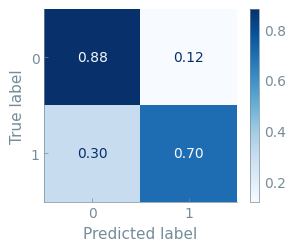

In [55]:
index_maxsize = compiled_res[compiled_res["train_size"]==max(compiled_res["train_size"])].index
conf_mats_max = [conf_mats[i] for i in index_maxsize]

actual_all, predicted_all = [], []
for index, _ in enumerate(conf_mats_max):
    preds = conf_mats_max[index]
    actual = preds["all_y_true"]
    predicted = preds["all_y_pred"]
    
    for true, pred in zip(actual, predicted):
        actual_all.append(true)
        predicted_all.append(pred)

confusion_matrix = metrics.confusion_matrix(actual_all, predicted_all)
confusion_matrix_norm = confusion_matrix.astype("float") / confusion_matrix.sum(axis=1)[:, np.newaxis]
print(confusion_matrix_norm)

cm = pycm.ConfusionMatrix(list(actual_all), list(predicted_all))
acc = cm.Overall_ACC

print(f'accuracy: {acc}')

cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix_norm, display_labels = [0, 1])
cm_display.plot(cmap=plt.cm.Blues, include_values=True, values_format=".2f")
#plt.savefig('classif_viscosity_confusionMatrix_50_50_size80_XGBoost.pdf', bbox_inches='tight')